In [1]:
import hoomd
import hoomd.md
#import hoomd.md.methods.thermostats
#import hoomd.write.gsd
import gsd.hoomd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
sys.path.append('../../MC-DFM')
sys.path.append('../../../MC-DFM')
from Scattering_Simulator import pairwise_method  #as pairwise_method
from scipy.spatial.transform import Rotation as R
#from IPython import get_ipython
from scipy.interpolate import interp1d
import pandas as pd
from apdist.distances import AmplitudePhaseDistance
import torch
from scipy.signal import find_peaks

## Load Experimental Data

use hoomd_2.9.4_botorch

In [4]:
def simulation(density, U_0, r0, n, m, save_dir):
    # === Initialize HOOMD ===
    hoomd.context.initialize("--mode=cpu")  # or "--mode=gpu" if needed
    os.makedirs(save_dir, exist_ok=True)
    # === User-defined simulation parameters ===
    N = 1000                  # number of spheres change for hyak back to 5000
    dt = 0.001                # time step
    steps = 100000             # number of steps change for hyak
    kT = 1.0                  # temperature for Langevin thermostat
    #density = 0.0005 #range from 0.0005 to 0.005
    rmin = 0.75*r0
    rmax = 5
    #m = 12

    # === Compute box size from density ===
    volume = N / density
    L = volume ** (1.0 / 3.0)

    # === Generate non-overlapping initial positions ===
    def generate_positions(N, L, min_dist):
        positions = []
        attempts = 0
        max_attempts = N * 1000
        while len(positions) < N and attempts < max_attempts:
            pos = np.random.uniform(-L/2, L/2, 3)
            if all(np.linalg.norm(pos - np.array(p)) >= min_dist for p in positions):
                positions.append(pos)
            attempts += 1
        if len(positions) < N:
            raise RuntimeError("Failed to generate non-overlapping configuration.")
        return positions

    positions = generate_positions(N, L, min_dist=1.1)

    # === Create initial snapshot ===
    snapshot = hoomd.data.make_snapshot(N=N,
                                        box=hoomd.data.boxdim(L=L),
                                        particle_types=['A'])
    for i in range(N):
        snapshot.particles.position[i] = positions[i]
        snapshot.particles.diameter[i] = 1.0  

    system = hoomd.init.read_snapshot(snapshot)

    def modified_LJ(r, rmin, rmax, U_0, n, m, r0):
        U = U_0/(n - m) * (m*(r0/r)**n - n*(r0/r)**m)
        F = U_0*m*n*((r0/r)**n - (r0/r)**m)/((n-m)*r)
        return U, F

    width = 1000 # number of points to evaluate the pair potential
    for r in np.linspace(rmin, rmax, width):
        u, f = modified_LJ(r, rmin, rmax, U_0, n, m, r0)
        assert np.isfinite(u), f"U not finite at r={r}"
        assert np.isfinite(f), f"F not finite at r={r}"


    r_vals = np.linspace(rmin, rmax, width)
    U, F = modified_LJ(r_vals, rmin, rmax, U_0, n, m, r0)
    plt.figure(figsize=(6, 4))
    plt.plot(r_vals, U, label=f'LJ-nm: n={n}, m={m}, r₀={r0}, U_0={U_0}')
    plt.xlabel("r")
    plt.ylabel("Potential Energy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_dir + "/potential_plot.png", dpi=600, bbox_inches="tight")
    plt.close()

    # === Langevin dynamics ===
    group_all = hoomd.group.all()
    hoomd.md.integrate.mode_standard(dt=dt)
    langevin = hoomd.md.integrate.langevin(group=group_all, kT=kT, seed=42)
    langevin.set_gamma('A', gamma=1.0)

    nl = hoomd.md.nlist.cell()

    table = hoomd.md.pair.table(width=width, nlist=nl)
    table.pair_coeff.set('A', 'A', rmin=rmin, rmax=rmax, func=modified_LJ, coeff=dict(U_0=U_0, n=n, m=m, r0=r0))

    now = time.localtime()
    timestamp = f"{now.tm_year:02d}{now.tm_mon:02d}{now.tm_mday:02d}{now.tm_hour:02d}{now.tm_min:02d}{now.tm_sec:02d}"
    filename = save_dir + f"/DNA_assembly_{timestamp}.gsd"
    # === Output trajectory to GSD ===
    hoomd.dump.gsd(filename=filename,
                period=1000,   #change back to 50000 for hyak
                group=group_all,
                overwrite=True)

    # === Log potential energy to CSV ===
    hoomd.analyze.log(filename= save_dir + '/potential_energy.csv',
                    quantities=['potential_energy'],
                    period=5000,
                    overwrite=True)

    # === Run simulation ===
    print(f"Running {steps} steps with {N} spheres at density {density:.3f}")
    hoomd.run(steps)
    print("Simulation complete.")

    df = pd.read_csv(save_dir + "/potential_energy.csv", delimiter='\t').values
    plt.figure(figsize=(6, 4))
    plt.plot(df[6:,0], df[6:,1], label='Potential Energy')
    plt.xlabel("Time")
    plt.ylabel("Potential Energy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_dir + "/potential_energy_plot.png", dpi=600, bbox_inches="tight")
    plt.close()



# def save_last_cell(filename="last_cell.py"):
#     ip = get_ipython()
#     last_cell_number = ip.execution_count - 1
#     code = ip.history_manager.input_hist_raw[last_cell_number]
#     with open(filename, 'w') as f:
#         f.write(code)

def extract_positions_orientations(filename):
    """
    Extract positions and orientations from each frame of a GSD file.

    Parameters
    ----------
    filename : str
        Path to the GSD trajectory file.

    Returns
    -------
    positions : list of np.ndarray
        List of arrays of shape (N, 3) with particle positions per frame.
    orientations : list of np.ndarray or None
        List of arrays of shape (N, 4) with quaternions per frame,
        or None if not present in the frame.
    """
    traj = gsd.hoomd.open(name=filename, mode='r')

    positions = []
    orientations = []

    for frame in traj:
        positions.append(frame.particles.position.copy())

        if hasattr(frame.particles, 'orientation'):
            orientations.append(frame.particles.orientation.copy())
        else:
            orientations.append(None)

    orientations_euler = []
    for i in range(len(orientations)):
        angles = quaternion_to_euler(orientations[i][:, :]) 
        orientations_euler.append(angles)

    lattice_coordinates = []
    for i in range(len(orientations_euler)):
        lattice_coordinates.append(np.hstack((positions[i][:, :], orientations_euler[i][:, :])))
    
    return lattice_coordinates


def quaternion_to_euler(quat, degrees=True, order='xyz'):
    """
    Convert a quaternion (HOOMD format: [qw, qx, qy, qz]) to Euler angles.

    Parameters:
    - quat: array-like, quaternion [qw, qx, qy, qz]
    - degrees: bool, return angles in degrees if True (default), radians if False
    - order: str, axes sequence for Euler angles ('xyz', 'zyx', etc.)

    Returns:
    - tuple of 3 Euler angles (angle_x, angle_y, angle_z)
    """
    # Convert to scipy format (qx, qy, qz, qw)
    #scipy_quat = [quat[1], quat[2], quat[3], quat[0]]
    scipy_quat = quat
    r = R.from_quat(scipy_quat)
    angles = r.as_euler(order, degrees=degrees)
    return angles

def grid_points_in_sphere(D, spacing):
    """
    Generate a regular 3D grid of points spaced by 'spacing' that fit inside a sphere.

    Parameters
    ----------
    D : float
        Diameter of the sphere.
    spacing : float
        Distance between adjacent grid points.

    Returns
    -------
    points : np.ndarray of shape (M, 3)
        Grid points inside the sphere.
    """
    radius = D / 2.0
    r2 = radius ** 2

    # Create a 3D grid
    coords = np.arange(-radius, radius + spacing, spacing)
    X, Y, Z = np.meshgrid(coords, coords, coords)
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Keep only the points inside the sphere
    mask = np.sum(grid**2, axis=1) <= r2
    points = grid[mask]

    return points


def fill_cube_with_points(N, edge_length):
    """
    Fill a cube with N points approximately uniformly distributed.

    Parameters
    ----------
    N : int
        Number of points to place inside the cube.
    edge_length : float
        Length of each edge of the cube.

    Returns
    -------
    points : np.ndarray of shape (N, 3)
        Coordinates of the points inside the cube.
    """
    # Estimate number of points per side of the grid
    n_side = int(np.ceil(N ** (1/3)))
    spacing = edge_length / n_side

    # Create grid
    coords = np.linspace(-edge_length / 2 + spacing / 2,
                          edge_length / 2 - spacing / 2,
                          n_side)

    X, Y, Z = np.meshgrid(coords, coords, coords)
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Select only the first N points
    points = grid[:N]

    return points


def compare_saxs_curves(exp_data, sim_data, q_range=None, scale_intensity=True):
    """
    Compare two SAXS curves in log space.

    Parameters:
        exp_data: np.ndarray with shape (N1, 2), [q, I(q)]
        sim_data: np.ndarray with shape (N2, 2), [q, I(q)]
        q_range: tuple (q_min, q_max), optional range for comparison
        scale_intensity: bool, if True, scales simulated intensity to best match experimental

    Returns:
        mse: float, mean squared error in log10 scale
        q_ref: np.ndarray of q values used for comparison
        I_exp_resampled, I_sim_resampled: np.ndarray of resampled (and scaled) intensities
    """
    # Extract q and I
    q_exp, I_exp = exp_data[:, 0], exp_data[:, 1]
    q_sim, I_sim = sim_data[:, 0], sim_data[:, 1]

    # Determine overlapping q-range
    q_min_common = max(q_exp.min(), q_sim.min())
    q_max_common = min(q_exp.max(), q_sim.max())

    # Apply user-specified q_range if provided
    if q_range is not None:
        q_min_user, q_max_user = q_range
        q_min_common = max(q_min_common, q_min_user)
        q_max_common = min(q_max_common, q_max_user)

    # Truncate both curves
    mask_exp = (q_exp >= q_min_common) & (q_exp <= q_max_common)
    mask_sim = (q_sim >= q_min_common) & (q_sim <= q_max_common)
    q_exp_crop, I_exp_crop = q_exp[mask_exp], I_exp[mask_exp]
    q_sim_crop, I_sim_crop = q_sim[mask_sim], I_sim[mask_sim]

    # Resample to match shorter curve
    if len(q_exp_crop) <= len(q_sim_crop):
        q_ref = q_exp_crop
        I_exp_resampled = I_exp_crop
        I_sim_resampled = interp1d(q_sim_crop, I_sim_crop, kind='linear', bounds_error=False, fill_value='extrapolate')(q_ref)
    else:
        q_ref = q_sim_crop
        I_sim_resampled = I_sim_crop
        I_exp_resampled = interp1d(q_exp_crop, I_exp_crop, kind='linear', bounds_error=False, fill_value='extrapolate')(q_ref)

    # Avoid log(0) by clipping
    eps = 1e-10
    I_exp_resampled = np.clip(I_exp_resampled, eps, None)
    I_sim_resampled = np.clip(I_sim_resampled, eps, None)


    # Find peaks
    # peaks_exp, _ = find_peaks(I_exp_resampled)
    # peaks_sim, _ = find_peaks(I_sim_resampled)

    # if len(peaks_exp) == 0 or len(peaks_sim) == 0:
    #     scale_factor = np.sum(I_exp_resampled * I_sim_resampled) / np.sum(I_sim_resampled ** 2)
    #     I_sim_scaled = I_sim_resampled * scale_factor
    # else:
    #     # Find the most prominent peak in each (maximum intensity among peaks)
    #     peak_val_exp = I_exp_resampled[peaks_exp].max()
    #     peak_val_sim = I_sim_resampled[peaks_sim].max()

    #     # Compute scale factor
    #     scale_factor = peak_val_exp / peak_val_sim

    #     # Apply scaling
    #     I_sim_scaled = I_sim_resampled * scale_factor
    
    scale_factor = np.mean(I_exp_resampled[-6:-1])/np.mean(I_sim_resampled[-6:-1])
    I_sim_scaled = I_sim_resampled*scale_factor
    # Intensity scaling (in linear space)
    #if scale_intensity:
    #    scale_factor = np.sum(I_exp_resampled * I_sim_resampled) / np.sum(I_sim_resampled ** 2)
    #    I_sim_resampled *= scale_factor

    # Convert to log10 for SAXS comparison
    log_I_exp = np.log10(I_exp_resampled)
    log_I_sim = np.log10(I_sim_scaled)

    # Compute MSE in log space
    #d_ap = mean_squared_error(log_I_exp, log_I_sim)
    # np.save('q_ref.npy', q_ref)
    # np.save('log_I_exp.npy', log_I_exp)
    # np.save('log_I_sim.npy', log_I_sim)
    # fig, ax = plt.subplots()
    # plt.plot(q_ref, log_I_exp)
    # plt.plot(q_ref, log_I_sim)
    # plt.savefig('TEST.png')
    # plt.close()
    q_AP = np.linspace(q_ref[0], q_ref[-1], len(q_ref))
    da, dp = AmplitudePhaseDistance(q_AP, log_I_exp, log_I_sim)
    d_ap = da + dp
    
    return d_ap, q_ref, I_exp_resampled, I_sim_scaled

# def run_simulation(U_0, n, m, r0, save_dir):
#     #save_dir = 'Sigma_2.33_eps_3_rcut_2.5'
#     #simulation(10_000, density, epsilon, sigma, r_cut, save_dir)
#     simulation(U_0, n, m, r0, save_dir)
#     save_last_cell(save_dir + "/simulation_file.py")



def normalize_scattering_curves(q, I1, I2, q_min, q_max):
    """
    Normalizes the second scattering curve to match the first within the q-range [q_min, q_max].

    Parameters:
        data (np.ndarray): 2D array with shape (N, 3), where
                           - column 0: q values,
                           - column 1: intensity of curve 1,
                           - column 2: intensity of curve 2
        q_min (float): lower bound of q-range for normalization
        q_max (float): upper bound of q-range for normalization

    Returns:
        np.ndarray: New array with same shape as input, with column 2 normalized
    """
    # Mask to select points within the given q-range
    mask = (q >= q_min) & (q <= q_max)
    if not np.any(mask):
        raise ValueError("No data points found within the specified q-range.")
    # Calculate normalization factor
    scale_factor = np.mean(I1[mask]) / np.mean(I2[mask])
    # Apply normalization
    I2_normalized = I2 * scale_factor
    # Return the combined array
    return I2_normalized


def calculate_structure_factor(data0, data2, q_min, q_max, plot):
    new_data_2 = convert_data(data0, data2)
    fig, ax = plt.subplots(figsize=(7,7))
    normalized_data = normalize_scattering_curves(new_data_2[:,0], new_data_2[:,1], data0[:,1], q_min, q_max)
    plt.scatter(data0[:,0], normalized_data, color = 'blue', label = 'data0')
    plt.scatter(new_data_2[:,0], new_data_2[:,1], color = 'red', label = 'data2')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Intensity (arb. unit)')
    plt.xlabel('q ($\\AA^{-1}$)')
    if plot == False:
        plt.close()
    structure_factor = new_data_2[:,1]/((normalized_data))
    structure_factor = np.hstack((new_data_2[:,0].reshape(-1,1), structure_factor.reshape(-1,1)))
    return structure_factor

def convert_data(data, model):
    model_x = model[:,0]
    model_y = model[:,1]
    index = np.linspace(0, len(model_x)-1, len(model_x)) 
    model_q_new = []
    model_I_new = []
    for i in range(len(data)):
        data_q = data[i,0]
        array = np.abs(model_x - data_q)
        array = np.hstack((array.reshape(-1,1), index.reshape(-1,1)))
        array = array[np.argsort(array[:, 0])]
        loc = int(array[0,1])
        model_q_new.append(model_x[loc])
        model_I_new.append(model_y[loc])
    q = np.array(model_q_new).reshape(-1,1)
    I = np.array(model_I_new).reshape(-1,1)
    new_model_data = np.hstack((q, I))
    return new_model_data

def sphere(q, r):
    return 3*(np.sin(q*r) - q*r*np.cos(q*r))**2/(q*r)**6

def convert_to_SAXS(save_dir):
    filenames = sorted(os.listdir(save_dir))
    file_path = save_dir + '/' + filenames[0] #This is the path to the .gsd file 
    lattice_coordinates = extract_positions_orientations(file_path)

    #Sphere
    D = 1            # diameter of the sphere
    spacing = 0.03    # spacing between grid points
    points = grid_points_in_sphere(D, spacing)
    ones = np.array([1]*len(points))
    points = np.hstack((points, ones.reshape(-1,1)))

    ################################## INPUTS ##########################################################################################

    plot_every_n_frame = 50            # Determines how many SAXS simulations occur per frame  
    histogram_bins = 10000            # Number of bins in the pairwise distribution calculation 
    q = np.geomspace(0.8, 20, 2000)  # SAXS q-range to be calculated
    path = save_dir + '/scattering_data/'  # Where to save the files and plot
    path_intensity = save_dir + '/scattering_data_intensity/'
    ####################################################################################################################################

    os.makedirs(save_dir + '/scattering_data', exist_ok=True)
    os.makedirs(save_dir + '/scattering_data_intensity', exist_ok=True)
    frames = len(lattice_coordinates)
    cmap = cm.jet
    norm = plt.Normalize(0, frames - 1)
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize=(10,7))

    for i in range(1,5):
        n_samples = 10000000
        simulator = pairwise_method.scattering_simulator(n_samples)
        simulator.sample_building_block(points)
        simulator.sample_lattice_coordinates(lattice_coordinates[-i])
        simulator.calculate_structure_coordinates()
        #I_q = simulator.simulate_multiple_scattering_curves_lattice_coords(points, lattice_coordinates[-i], histogram_bins, q, save=False).cpu().numpy()
        #I_q = np.mean(I_q, axis=1)
        I_q = simulator.simulate_scattering_curve_fast_lattice(points, lattice_coordinates[-i], histogram_bins, q, save=False).cpu().numpy()
        plt.rcParams.update({'font.size': 18})
        q_rescaled = q/260        
        ax.plot(q_rescaled, I_q, color='k', linewidth = 3, label = 'scattering curve')
        #ax.plot(S_q[:,0], S_q[:,1], color='k', linewidth = 3, label = 'Structure Factor')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('S(q)')
        ax.set_xlabel('q ($\\AA^{-1}$)')
        #plt.legend(fontsize=14)
        data = np.hstack((q_rescaled.reshape(-1,1), I_q.reshape(-1,1)))
        np.save(path_intensity + 'Intensity_plot' + str(-i) + '.npy', data) 
        plt.savefig(path_intensity + 'Intensity_plot' + str(-i) + '.png', dpi=600, bbox_inches="tight")

        q_sphere = np.geomspace(0.003, 0.08, 500)
        I_sphere = sphere(q_sphere, 130)
        monodisperse_sphere = np.hstack((q_sphere.reshape(-1,1), I_sphere.reshape(-1,1)))
        #S_q = calculate_structure_factor(monodisperse_sphere, I_q, 0.02, 0.03, False)
        S_q = calculate_structure_factor(monodisperse_sphere, np.hstack((q_rescaled.reshape(-1,1), I_q.reshape(-1,1))), 0.02, 0.03, False)
        #S_q = calculate_structure_factor(monodisperse_sphere, I_q, 0.02, 0.03, False)
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(S_q[:,0], S_q[:,1], color='k', linewidth = 3, label = 'Structure Factor')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('S(q)')
        ax.set_xlabel('q ($\\AA^{-1}$)')
        #plt.legend(fontsize=14)
        #data = np.hstack((q_rescaled.reshape(-1,1), S_q.reshape(-1,1)))
        np.save(path + 'structure_factor' + str(-i) + '.npy', S_q)   
        # sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([]) 
        # cbar = plt.colorbar(sm, ax=ax)
        # cbar.set_label('Frame')
        plt.savefig(path + 'structure_factor_plot' + str(-i) + '.png', dpi=600, bbox_inches="tight")
        if i == 0:
            all_Sq = S_q[:,1].reshape(-1,1)
        else:
            all_Sq = np.hstack((all_Sq, S_q[:,1].reshape(-1,1)))
    plt.close()
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(S_q[:,0], np.mean(all_Sq, axis=1), color='k', linewidth = 3, label = 'average S(q)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Intensity (arb. unit)')
    ax.set_xlabel('q ($\\AA^{-1}$)')
    plt.savefig(path + 'scattering_curve_plot_average.png', dpi=600, bbox_inches="tight")
    plt.close()
    data = np.hstack((S_q[:,0].reshape(-1,1), np.mean(all_Sq, axis=1).reshape(-1,1)))
    np.save(path + 'average_structure_factor.npy', data)


def compare_to_exp(experimental_data, simulated_data, save_dir):
    q = [0.003, 0.03]
    mse, q_ref, I_exp_resampled, I_sim_resampled = compare_saxs_curves(experimental_data, simulated_data, q)
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize=(7,6))      
    ax.scatter(q_ref, I_exp_resampled, linewidth = 0.5, label = 'Exp_data', color='k')
    ax.plot(q_ref, I_sim_resampled, linewidth = 3, label = 'Sim_data', color='red')
    #ax.set_xlim([0.004, 0.03])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Intensity (arb. unit)')
    ax.set_xlabel('q ($\\AA^{-1}$)')
    plt.title(str(mse))
    plt.legend()
    plt.savefig(save_dir + '/compare_to_exp.png', dpi=600, bbox_inches="tight")
    plt.close()

    q = [0.003, 0.07]
    mse2, q_ref, I_exp_resampled, I_sim_resampled = compare_saxs_curves(experimental_data, simulated_data, q)
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize=(7,6))
    ax.scatter(q_ref, I_exp_resampled, linewidth = 0.5, label = 'Exp_data', color='k')
    ax.plot(q_ref, I_sim_resampled, linewidth = 3, label = 'Sim_data', color='red')
    #ax.set_ylim([np.min(I_exp_resampled), np.max(I_exp_resampled)])
    #ax.set_xlim([0.004, 0.03])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Intensity (arb. unit)')
    ax.set_xlabel('q ($\\AA^{-1}$)')
    plt.title(str(mse2))
    plt.legend()
    plt.savefig(save_dir + '/compare_to_exp_full_curve.png', dpi=600, bbox_inches="tight")
    plt.close()
    return mse

def objective(Experiment_Name, iteration, Sample, param_names, *simulation_inputs):
    # Handle torch.Tensor input (e.g., if passed as *tensor instead of separate floats)
    if len(simulation_inputs) == 1 and isinstance(simulation_inputs[0], (torch.Tensor, np.ndarray, list)):
        simulation_inputs = simulation_inputs[0]

    # Convert to NumPy and flatten
    if isinstance(simulation_inputs, torch.Tensor):
        simulation_inputs = simulation_inputs.detach().cpu().numpy()
    simulation_inputs = np.asarray(simulation_inputs).flatten()

    # Define parameter names (update as needed)
    #param_names = ['Density', 'U_0', 'r0']
    if len(simulation_inputs) != len(param_names):
        raise ValueError(f"Expected {len(param_names)} parameters but got {len(simulation_inputs)}.")

    # Create directory structure
    #Iteration_Name = f'Iteration_{iteration}'
    Iteration_Name = f'Optimization_Results'
    Sample_Name = f'Sample_{Sample}'
    sample_dir = os.path.join(Experiment_Name, Iteration_Name, Sample_Name)
    os.makedirs(sample_dir, exist_ok=True)

    # Save input parameters
    df = pd.DataFrame([simulation_inputs], columns=param_names)
    df.to_csv(os.path.join(sample_dir, 'input_params.csv'), index=False)

    # Load experimental data
    #exp_data = np.load('Experimental_data/close_packed_aggregates.npy')[:-200, :]
    exp_data_scattering = np.load('../Experimental_data/bridge_20.npy')[:-200, :]


    # Convert to structure Factor 
    sphere_polydisperse = np.loadtxt('../Experimental_data/sasmodels_sphere_fit.txt', skiprows=1)
    exp_data = calculate_structure_factor(sphere_polydisperse, exp_data_scattering, 0.02, 0.03, False)

    # Build directory name from parameter values
    param_strs = [f"{name}_{np.round(val, 5)}" for name, val in zip(param_names, simulation_inputs)]
    save_dir = os.path.join(sample_dir, "_".join(param_strs))
    os.makedirs(save_dir, exist_ok=True)

    try:
        simulation(*simulation_inputs, save_dir)
        print('Converting Simulation to SAXS')
        convert_to_SAXS(save_dir)

        print('Compare to Experimental Data')
        sim_data = np.load(os.path.join(save_dir, 'scattering_data/average_structure_factor.npy'))
        score = compare_to_exp(exp_data, sim_data, save_dir)

        print('Score: ', score)
        pd.DataFrame([score]).to_csv(os.path.join(sample_dir, f'Score_{score}.csv'), index=False)
    except Exception as e:
        print(f'Simulation failed: {e}')
        score = 999
    return score


HOOMD-blue 2.9.4 CUDA (11.2) DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 02/22/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.


-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1000 particles
notice(2): integrate.langevin/bd is using specified gamma values
Running 100000 steps with 1000 spheres at density 0.005
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 31352 / 100000 | TPS 3135.17 | ETA 00:00:21
Time 00:00:20 | Step 58321 / 100000 | TPS 2696.87 | ETA 00:00:15
Time 00:00:30 | Step 88421 / 100000 | TPS 3009.95 | ETA 00:00:03
Time 00:00:34 | Step 100000 / 100000 | TPS 3038.43 | ETA 00:00:00
Average TP

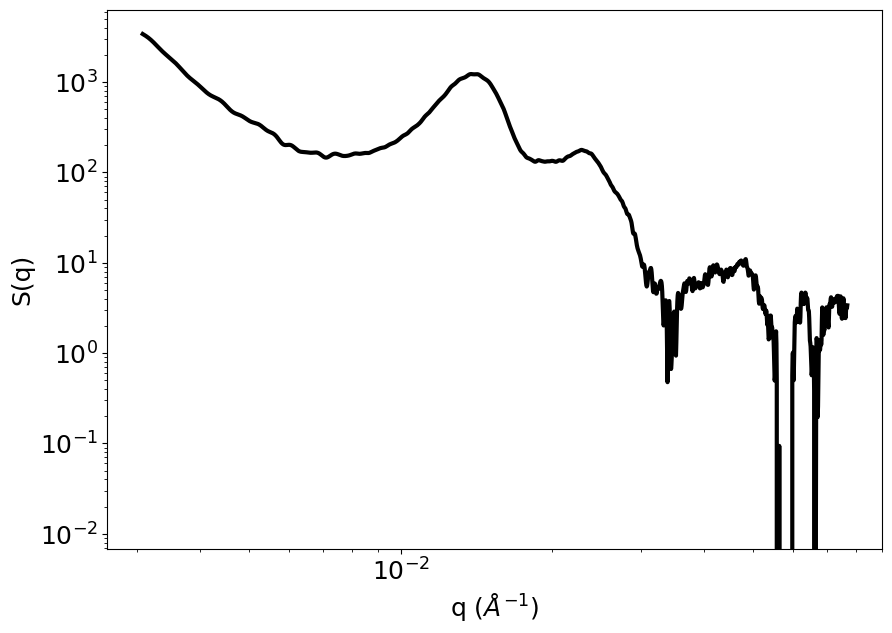

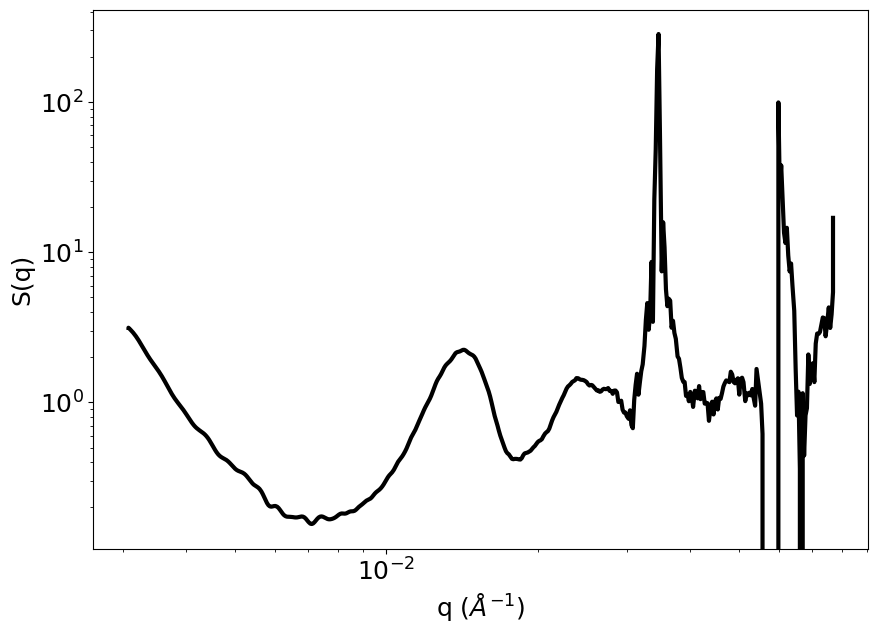

In [5]:
#Experiment Inputs
Density = 0.005
U_0 = 46.95
r0= 2.25
n = 1.0
m = 20.89

# Location to Save File
Experiment_Name = 'Simulation_File_9'
iteration = 'Ite'
Sample = 0
#Sample=24
#mse = objective(Experiment_Name, iteration, Sample, Density, U_0, r0)

x_physical = np.array([Density, U_0, r0, n, m])
param_names = ['Density', 'U_0', 'r0', 'n','m']  # Extend or change as needed
mse = objective(Experiment_Name, iteration, Sample, param_names, *x_physical)

Sample = Sample + 1

#%% [markdown]
## Run Optimization of the Simulation Parameters in a Loop 

In [ ]:

import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement 
from botorch.optim.optimize import optimize_acqf
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood

# %%
############### INPUTS of Optimization ################
Experiment_Name = '20_Bridge_250803'
n_iters = 100 # change for hyak
param_names = ['Density', 'U_0', 'r0', 'n', 'm']  # Extend or change as needed
target_mins = torch.tensor([0.00005, 0.1, 2.15, 1, 1], dtype=torch.float64) #hyak
target_maxs = torch.tensor([0.005, 150, 2.25, 30, 30], dtype=torch.float64) #hyak


# target_mins = torch.tensor([0.01, 30, 2.25, 10, 10], dtype=torch.float64)
# target_maxs = torch.tensor([0.05, 100, 2.45, 20, 20], dtype=torch.float64)


#######################################################

# Evaluate the objective function at each input point
# and store the results in a column vector (5x1)
y_values = []
iteration = 0
dtype = torch.float64
# === Define bounds for optimizer in [0, 1] ===
bounds = torch.tensor([[0]*len(target_maxs), [1]*len(target_maxs)], dtype=dtype)
dimensions = len(target_mins)
# === Scaling function for vectorized input ===
def scale_to_range(x_scaled, mins, maxs):
    return mins + x_scaled * (maxs - mins)
# === Initialize training data in [0, 1] ===
train_x = torch.rand(1, len(bounds[0]), dtype=dtype)

# === Evaluate physical objective on scaled inputs ===
y_values = []
for i, x in enumerate(train_x):
    x_physical = scale_to_range(x.unsqueeze(0), target_mins, target_maxs).squeeze(0)
    print('Inputs: ', x_physical)
    #y = objective(Experiment_Name, iteration, i, x_physical[0], x_physical[1], x_physical[2])  # evaluate objective
    y = objective(Experiment_Name, iteration, i, param_names, *x_physical)
    y_values.append(y)
    print(' ')

train_y = torch.tensor(y_values, dtype=dtype).unsqueeze(-1)

# === Manual GP fitting using Adam ===
def fit_gpytorch_model_with_adam(mll, lr=0.01, steps=100):
    mll.train()
    mll.model.train()
    optimizer = torch.optim.Adam(mll.parameters(), lr=lr)
    for _ in range(steps):
        optimizer.zero_grad()
        output = mll.model(mll.model.train_inputs[0])
        loss = -mll(output, mll.model.train_targets)
        loss.backward()
        optimizer.step()
    mll.eval()
    mll.model.eval()

# === Bayesian Optimization Loop ===
best_score_lst = [y]
for i in range(1, n_iters):
    neg_train_y = -train_y

    kernel = ScaleKernel(
        RBFKernel(ard_num_dims=len(bounds[0]), lengthscale_constraint=GreaterThan(1e-3)),
        outputscale_constraint=GreaterThan(1e-3)
    )
    likelihood = GaussianLikelihood(noise_constraint=GreaterThan(1e-4))

    model = SingleTaskGP(train_x, neg_train_y, covar_module=kernel, likelihood=likelihood)
    model.covar_module.outputscale = torch.tensor(1.0, dtype=dtype)
    model.covar_module.base_kernel.lengthscale = torch.tensor(0.2, dtype=dtype)
    model.likelihood.noise = torch.tensor(1e-2, dtype=dtype)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model_with_adam(mll)

    acq_func = qLogExpectedImprovement(model=model, best_f=neg_train_y.max())

    # Optimize acquisition function
    new_x, _ = optimize_acqf(
        acq_func,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20
    )

    # Scale the new input to physical range before evaluating
    new_x_physical = scale_to_range(new_x, target_mins, target_maxs)
    y_values = []
    iteration = 0
    for j, x in enumerate(new_x_physical):
        print('Inputs: ', new_x_physical)
        #y = objective(Experiment_Name, iteration, i, new_x_physical[0, 0], new_x_physical[0, 1], new_x_physical[0, 2])
        y = objective(Experiment_Name, iteration, i, param_names, *new_x_physical)
        y_values.append([y])  # keep inner list to match shape (q, 1)

    new_y = torch.tensor(y_values, dtype=dtype)

    train_x = torch.cat([train_x, new_x], dim=0)
    train_y = torch.cat([train_y, new_y], dim=0)

    print(f"Iter {i+1}:")
    print(f"  Scaled input (in [0,1]):   {new_x.squeeze().tolist()}")
    print(f"  Physical input (scaled):  {new_x_physical.squeeze().tolist()}")
    print(f"  Objective value:          {new_y.item():.6f}")

    # === Final result ===
    best_idx = train_y.argmin()
    best_x_scaled = train_x[best_idx]
    best_x_physical = scale_to_range(best_x_scaled.unsqueeze(0), target_mins, target_maxs).squeeze(0)

    print("\n=== Optimization Complete ===")
    print("Best scaled input (in [0,1]):", best_x_scaled.numpy())
    print("Best physical input:         ", best_x_physical.numpy())
    print("Best output (objective):     ", train_y[best_idx].item())
    print("Best Sample: ", best_idx.item())
    
    Iteration_Name = 'Optimization_Results'
    
    # columns = ['best_idx', 'best_x_scaled', 'best_x_physical', 'Best Score']
    # save_data = np.array([best_idx, best_x_scaled.numpy(), best_x_physical.numpy(), train_y[best_idx].item()])
    # df = pd.DataFrame(save_data, columns=columns)
    # df.to_csv(Experiment_Name + '/' + Iteration_Name + '/best_values.csv', index=False)
    
    iteration_ = np.linspace(0, i, i+1)
    best_score_lst.append(train_y[best_idx].item())
    fig, ax = plt.subplots(figsize=(7,7))
    plt.plot(iteration_, np.array(best_score_lst), linewidth = 3)
    plt.scatter(iteration_, np.array(best_score_lst), linewidth = 0.5)
    
    plt.savefig(Experiment_Name + '/' + Iteration_Name + '/score_plot.png', dpi=600, bbox_inches="tight")
    plt.close()
    print(' ')

# %%



